# 観光地選択巡回問題

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pulp

## ランダムインスタンス

In [2]:
np.random.seed(0)

# 範囲
R = 50

# 観光地候補数
N = np.random.randint(30, 40)

# 観光地候補集合
I = [i for i in range(N)]
start = I[0]

# 観光地の満足度
a = np.random.randint(1, 5, N)

# 観光地の滞在時間
b = np.random.randint(1, 2, N)

# 観光地候補間の移動距離(時間)
pos = np.random.randint(-R, R, (N, 2))  # 座標
speed = 40
d = [[np.linalg.norm(pos_i - pos_j, ord=2) / speed for pos_i in pos] for pos_j in pos]

# 観光費用(とりあえず0円)
c = np.zeros(N)

# 観光候補地間の交通費(とりあえず0円)
m = np.zeros((N, N), dtype=np.int)

# 観光制限時間
T = 10

# 観光制限費用(とりあえず0円)
C = 0

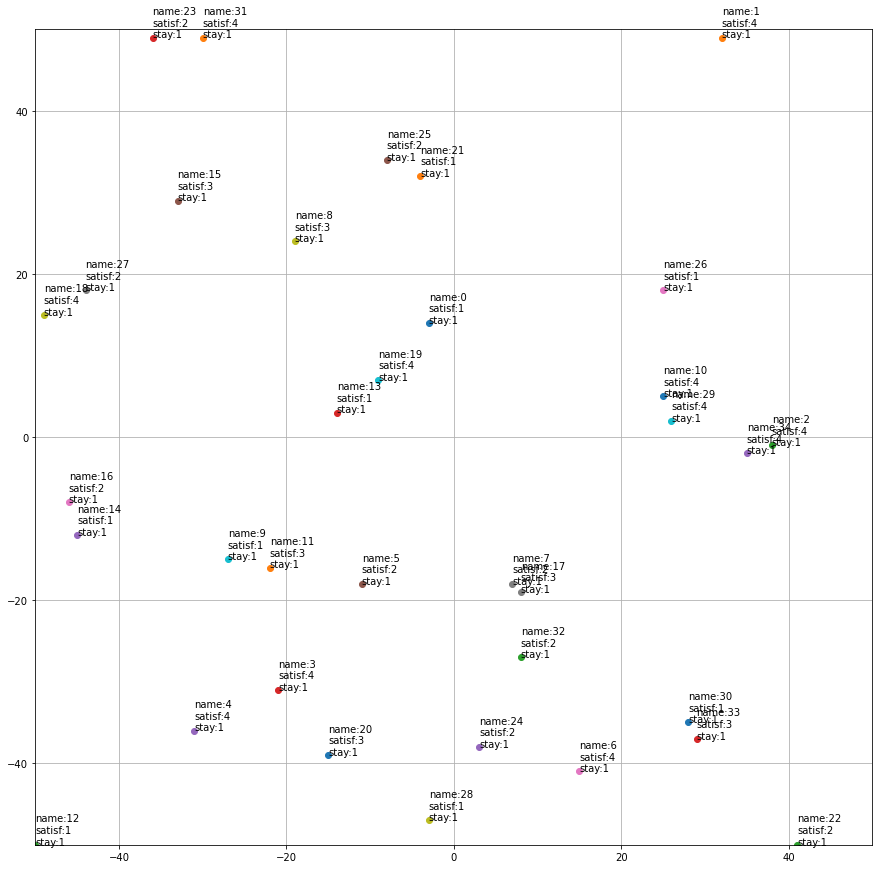

In [53]:
plt.figure(figsize=(15,15))

for pos_i, name_i, a_i, b_i in zip(pos, map(str, I), map(str, a), map(str, b)):
    plt.scatter(pos_i[0], pos_i[1])
    plt.annotate(f'name:{name_i}\nsatisf:{a_i}\nstay:{b_i}',
                 xy=(pos_i[0], pos_i[1]))

plt.xlim([-R,R])
plt.ylim([-R,R])
plt.grid()
plt.show()

## モデルの定義

In [13]:
# 数理最適化問題（最大化）を宣言
problem = pulp.LpProblem("problem", pulp.LpMaximize)

# 変数を定義
y = {}
for i in I:
    y[i] = pulp.LpVariable(f'y_{i}', 0, 1, pulp.LpInteger)

x = {}
for i in I:
    for j in I:
        if i != j:
            x[i,j] = pulp.LpVariable(f'x({i},{j})', 0, 1, pulp.LpInteger)
# 別表記
# x_suffixes = [(i,j) for i in I for j in I if i != j]
# x = pulp.LpVariable.dicts("x", 
#                           filter(lambda x: x != 0 ,x_suffixes), 
#                           cat = pulp.LpBinary)

f = {}
for i in I:
    for j in I:
        if i != j:
            f[i,j] = pulp.LpVariable(f'f({i},{j})', 0, N, pulp.LpInteger)

# 目的関数
objective = pulp.lpSum(a[i] * y[i] for i in I)
problem += objective

# 制約条件
## 時間制約
problem += sum(d[i][j] * x[i,j] for i in I for j in I if i != j) +\
            sum(b[i] * y[i] for i in I) <= T

## 費用制約
problem += sum(m[i][j] * x[i,j] for i in I for j in I if i != j) +\
            sum(c[i] * y[i] for i in I) <= C

## 観光地を訪れるのは各１回
for i in I:
    problem += sum(x[i,j] for j in I if i != j) == y[i]

for j in I:
    problem += sum(x[i,j] for i in I if i != j) == y[j]
    
## 部分巡回路を排除
for i in I:
    if i == start:
        for j in I:
            if i != j:
                problem += f[i,j] == 0
        continue
    
    problem += sum(f[h,i] for h in I if i != h) + y[i] == sum(f[i,j] for j in I if i != j)

for i in I:
    for j in I:
        if i != j:
            problem += f[i,j] <= N * x[i,j]

## スタート地点を必ず通るようにする
problem += y[start] == 1

In [14]:
print("問題の式")
print(f"-" * 8)
print(problem)
print(f"-" * 8)
print("")

問題の式
--------
problem:
MAXIMIZE
1*y_0 + 4*y_1 + 4*y_10 + 3*y_11 + 1*y_12 + 1*y_13 + 1*y_14 + 3*y_15 + 2*y_16 + 3*y_17 + 4*y_18 + 4*y_19 + 4*y_2 + 3*y_20 + 1*y_21 + 2*y_22 + 2*y_23 + 2*y_24 + 2*y_25 + 1*y_26 + 2*y_27 + 1*y_28 + 4*y_29 + 4*y_3 + 1*y_30 + 4*y_31 + 2*y_32 + 3*y_33 + 4*y_34 + 4*y_4 + 2*y_5 + 4*y_6 + 2*y_7 + 3*y_8 + 1*y_9 + 0
SUBJECT TO
_C1: 1.23743686708 x(0,1) + 0.735272058493 x(0,10) + 0.887764045228 x(0,11)
 + 1.98510075311 x(0,12) + 0.388908729653 x(0,13) + 1.23490890352 x(0,14)
 + 0.838525491562 x(0,15) + 1.20752846757 x(0,16) + 0.869626356546 x(0,17)
 + 1.15027170703 x(0,18) + 0.230488611432 x(0,19) + 1.09144399765 x(0,2)
 + 1.35853781692 x(0,20) + 0.450693909433 x(0,21) + 1.94164878389 x(0,22)
 + 1.20260134708 x(0,23) + 1.30862523283 x(0,24) + 0.515388203202 x(0,25)
 + 0.707106781187 x(0,26) + 1.0298664962 x(0,27) + 1.525 x(0,28)
 + 0.784617741324 x(0,29) + 1.21166208161 x(0,3) + 1.44956890143 x(0,30)
 + 1.10510180527 x(0,31) + 1.06124926384 x(0,32) + 1.50519932235 x

In [27]:
%%time

# 基本
solver = pulp.PULP_CBC_CMD()
result_status = problem.solve(solver)

CPU times: user 59.2 ms, sys: 10.3 ms, total: 69.5 ms
Wall time: 29.1 s


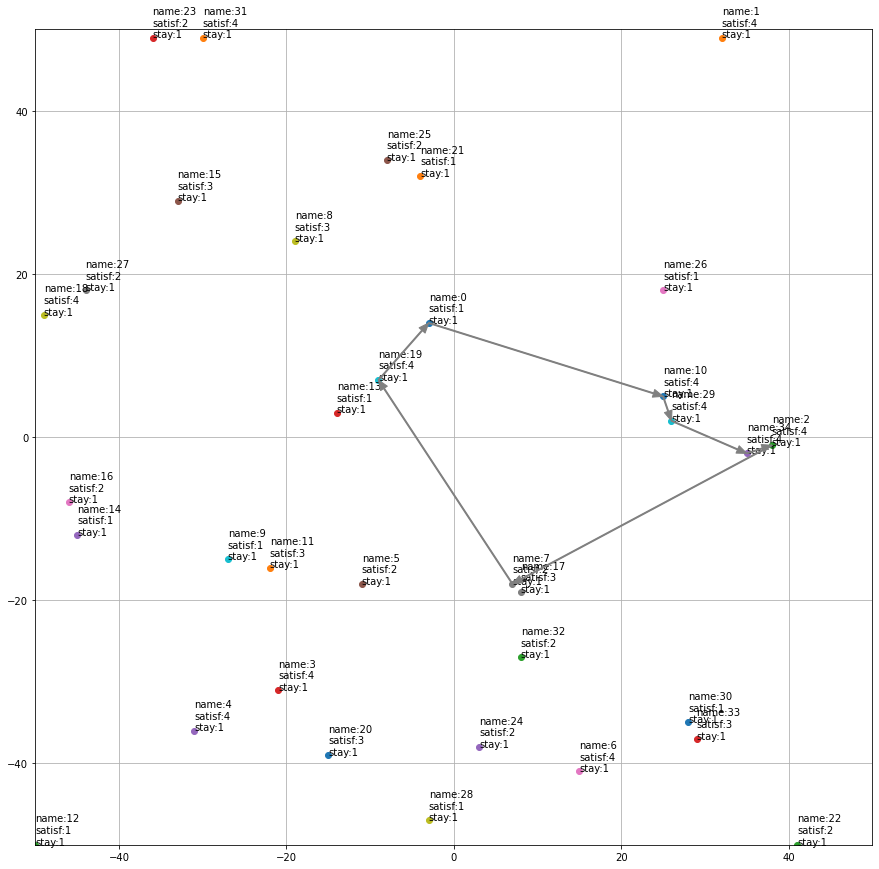

In [28]:
plt.figure(figsize=(15,15))

for pos_i, name_i, a_i, b_i in zip(pos, map(str, I), map(str, a), map(str, b)):
    plt.scatter(pos_i[0], pos_i[1])
    plt.annotate(f'name:{name_i}\nsatisf:{a_i}\nstay:{b_i}',
                 xy=(pos_i[0], pos_i[1]))

for i in I:
    for j in I:
        if i != j and x[i,j].value() == 1:
            plt.annotate('', xy=pos[i], xytext=pos[j], 
                         arrowprops=dict(shrink=0, width=1, headwidth=8, 
                                         headlength=10, connectionstyle='arc3',
                                         facecolor='gray', edgecolor='gray'))
                
plt.xlim([-R,R])
plt.ylim([-R,R])
plt.grid()
plt.show()

In [29]:
%%time

# 並列処理
solver = pulp.PULP_CBC_CMD(threads=4, timeLimit=1)
result_status = problem.solve(solver)

CPU times: user 39.4 ms, sys: 7.4 ms, total: 46.8 ms
Wall time: 1.13 s


In [30]:
print("計算結果")
print(f"*" * 8)
print(f"最適性 = {pulp.LpStatus[result_status]}, ", end="")
print(f"目的関数値 = {pulp.value(problem.objective)}, ", end="")
print("解 x[i,j]: ")
for i in I:
    for j in I:
        if i != j:
            print(f"{x[i,j].name} = {x[i,j].value()},  ", end="")
    print("")
for i in I:
    print(f"{y[i].name} = {y[i].value()},  ", end="")
print(f"*" * 8)

計算結果
********
最適性 = Optimal, 目的関数値 = 21.0, 解 x[i,j]: 
x(0,1) = 0.0,  x(0,2) = 0.0,  x(0,3) = 0.0,  x(0,4) = 0.0,  x(0,5) = 0.0,  x(0,6) = 0.0,  x(0,7) = 0.0,  x(0,8) = 0.0,  x(0,9) = 0.0,  x(0,10) = 0.0,  x(0,11) = 0.0,  x(0,12) = 0.0,  x(0,13) = 0.0,  x(0,14) = 0.0,  x(0,15) = 0.0,  x(0,16) = 0.0,  x(0,17) = 0.0,  x(0,18) = 0.0,  x(0,19) = 1.0,  x(0,20) = 0.0,  x(0,21) = 0.0,  x(0,22) = 0.0,  x(0,23) = 0.0,  x(0,24) = 0.0,  x(0,25) = 0.0,  x(0,26) = 0.0,  x(0,27) = 0.0,  x(0,28) = 0.0,  x(0,29) = 0.0,  x(0,30) = 0.0,  x(0,31) = 0.0,  x(0,32) = 0.0,  x(0,33) = 0.0,  x(0,34) = 0.0,  
x(1,0) = 0.0,  x(1,2) = 0.0,  x(1,3) = 0.0,  x(1,4) = 0.0,  x(1,5) = 0.0,  x(1,6) = 0.0,  x(1,7) = 0.0,  x(1,8) = 0.0,  x(1,9) = 0.0,  x(1,10) = 0.0,  x(1,11) = 0.0,  x(1,12) = 0.0,  x(1,13) = 0.0,  x(1,14) = 0.0,  x(1,15) = 0.0,  x(1,16) = 0.0,  x(1,17) = 0.0,  x(1,18) = 0.0,  x(1,19) = 0.0,  x(1,20) = 0.0,  x(1,21) = 0.0,  x(1,22) = 0.0,  x(1,23) = 0.0,  x(1,24) = 0.0,  x(1,25) = 0.0,  x(1,26) = 0.0,  x(1

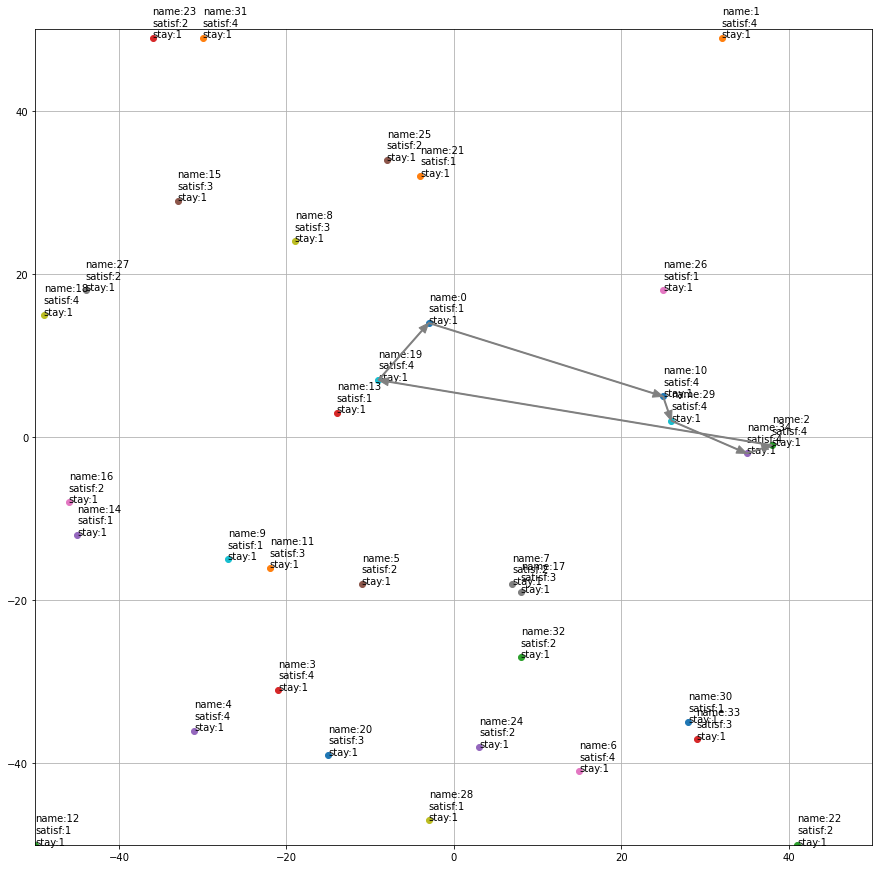

In [31]:
plt.figure(figsize=(15,15))

for pos_i, name_i, a_i, b_i in zip(pos, map(str, I), map(str, a), map(str, b)):
    plt.scatter(pos_i[0], pos_i[1])
    plt.annotate(f'name:{name_i}\nsatisf:{a_i}\nstay:{b_i}',
                 xy=(pos_i[0], pos_i[1]))

for i in I:
    for j in I:
        if i != j and x[i,j].value() == 1:
            plt.annotate('', xy=pos[i], xytext=pos[j], 
                         arrowprops=dict(shrink=0, width=1, headwidth=8, 
                                         headlength=10, connectionstyle='arc3',
                                         facecolor='gray', edgecolor='gray'))
                
plt.xlim([-R,R])
plt.ylim([-R,R])
plt.grid()
plt.show()

## クラス化

In [3]:
class PCTSP:
    """
    prize collecting traveling salesman problem

    Attributes
    ----------
    I : array of int
        観光地名id(0以上の連続した数列)
    a : array of int or float
        観光地の満足度
    b : array of int or float
        観光地の滞在時間
    pos : ndarray of float
        [[x座標, y座標]_pos1, [x座標, y座標]_pos2]
        観光地の座標
    speed : float or int
        移動速度
    c : array of int
        観光地ごとの費用
    m : ndarray(N,N)
        [観光地1[観光地1までの費用, 観光地2までの費用, ...], 
         観光地2[観光地1までの費用, 観光地2までの費用, ...], 
         ...
         ]
    x : dict
        {(0, 1): x(0,1),
         (0, 2): x(0,2),
         (0, 3): x(0,3),...
        }
        地点間の道を通るか否かの最適化問題の変数
    """
    
    def __init__(self, I, a, b, pos, speed, c, m):
        """        
        parameters
        ----------
        I : array of int
            観光地名id(0以上の連続した数列)
        a : array of int or float
            観光地の満足度
        b : array of int or float
            観光地の滞在時間
        pos : ndarray of float
            [[x座標, y座標]_pos1, [x座標, y座標]_pos2]
            観光地の座標
        speed : float or int
            移動速度
        c : array of int
            観光地ごとの費用
        m : ndarray(N,N)
            [観光地1[観光地1までの費用, 観光地2までの費用, ...], 
             観光地2[観光地1までの費用, 観光地2までの費用, ...], 
             ...
             ]
        """
        self.I = I
        self.a = a
        self.b = b
        self.c = c
        self.d = [[np.linalg.norm(pos_i - pos_j, ord=2) / speed for pos_i in pos] for pos_j in pos]
        self.m = m
        self.pos = pos
        
        
    def plot_map(self, x_min, x_max, y_min, y_max):
        """   
        マップの描画
        
        Parameters
        ----------
        x_min : float
            マップの描画範囲のx軸方向の最小値
        x_max : float
            マップの描画範囲のx軸方向の最大値
        x_min : float
            マップの描画範囲のy軸方向の最小値
        x_max : float
            マップの描画範囲のy軸方向の最大値
        """
        plt.figure(figsize=(15,15))

        for pos_i, name_i, a_i, b_i in zip(self.pos, map(str, self.I), 
                                           map(str, self.a), map(str, self.b)):
            plt.scatter(pos_i[0], pos_i[1])
            plt.annotate(f'name:{name_i}\nsatisf:{a_i}\nstay:{b_i}',
                         xy=(pos_i[0], pos_i[1]))

        plt.xlim([x_min, x_max])
        plt.ylim([y_min, y_max])
        plt.grid()
        plt.show()
        
    def plot_route(self, x, x_min, x_max, y_min, y_max):
        """   
        経路の描画
        
        Parameters
        ----------
        x : dict
            self.solveで得られた解
        x_min : float
            マップの描画範囲のx軸方向の最小値
        x_max : float
            マップの描画範囲のx軸方向の最大値
        x_min : float
            マップの描画範囲のy軸方向の最小値
        x_max : float
            マップの描画範囲のy軸方向の最大値
        """
        
        plt.figure(figsize=(15,15))
        for pos_i, name_i, a_i, b_i in zip(self.pos, map(str, self.I), 
                                           map(str, self.a), map(str, self.b)):
            plt.scatter(pos_i[0], pos_i[1])
            plt.annotate(f'name:{name_i}\nsatisf:{a_i}\nstay:{b_i}',
                         xy=(pos_i[0], pos_i[1]))

        for i in I:
            for j in I:
                if i != j and x[i,j].value() == 1:
                    plt.annotate('', xy=pos[i], xytext=pos[j], 
                                 arrowprops=dict(shrink=0, width=1, headwidth=8, 
                                                 headlength=10, connectionstyle='arc3',
                                                 facecolor='gray', edgecolor='gray'))

        plt.xlim([x_min, x_max])
        plt.ylim([y_min, y_max])
        plt.grid()
        plt.show()
    
    
    def formulate(self, start, T, C):
        """
        最適化問題を定式化
        
        Parameters
        ----------
        start : int
            初期地点
        T : float
            旅行時間
        C : int
            旅費
        
        Returns
        -------
        problem
            pulp形式の最適化問題
        
        """
        
        # 数理最適化問題（最大化）を宣言
        problem = pulp.LpProblem("problem", pulp.LpMaximize)

        # 変数を定義
        y = {}
        for i in self.I:
            y[i] = pulp.LpVariable(f'y_{i}', 0, 1, pulp.LpInteger)

        self.x = {}
        for i in self.I:
            for j in self.I:
                if i != j:
                    self.x[i,j] = pulp.LpVariable(f'x({i},{j})', 0, 1, pulp.LpInteger)

        f = {}
        for i in self.I:
            for j in self.I:
                if i != j:
                    f[i,j] = pulp.LpVariable(f'f({i},{j})', 0, len(self.I), pulp.LpInteger)

        # 目的関数
        objective = pulp.lpSum(self.a[i] * y[i] for i in self.I)
        problem += objective

        # 制約条件
        ## 時間制約
        problem += sum(self.d[i][j] * self.x[i,j] for i in self.I for j in self.I if i != j) +\
                    sum(self.b[i] * y[i] for i in self.I) <= T

        ## 費用制約
        problem += sum(self.m[i][j] * self.x[i,j] for i in self.I for j in self.I if i != j) +\
                    sum(self.c[i] * y[i] for i in self.I) <= C

        ## 観光地を訪れるのは各１回
        for i in self.I:
            problem += sum(self.x[i,j] for j in self.I if i != j) == y[i]

        for j in self.I:
            problem += sum(self.x[i,j] for i in self.I if i != j) == y[j]

        ## 部分巡回路を排除
        for i in self.I:
            if i == start:
                for j in self.I:
                    if i != j:
                        problem += f[i,j] == 0
                continue

            problem += sum(f[h,i] for h in self.I if i != h) + y[i] == sum(f[i,j] for j in self.I if i != j)

        for i in self.I:
            for j in self.I:
                if i != j:
                    problem += f[i,j] <= len(self.I) * self.x[i,j]

        ## スタート地点を必ず通るようにする
        problem += y[start] == 1
        
        return problem
    
    def solve(self, start, T, C, threads=4, timeLimit=1):
        """
        最適化問題を解く
        
        Attribute
        ---------
        start : int
            初期地点
        T : float
            旅行時間
        C : int
            旅費
        threads : int
            並列数
        timeLimit : int
            問題を解く制限時間
        
        Returns
        -------
        x
            最適化問題の解
        """
        problem = self.formulate(start, T, C)
        solver = pulp.PULP_CBC_CMD(threads=threads, timeLimit=timeLimit)
        result_status = problem.solve(solver)
        
        return self.x
        

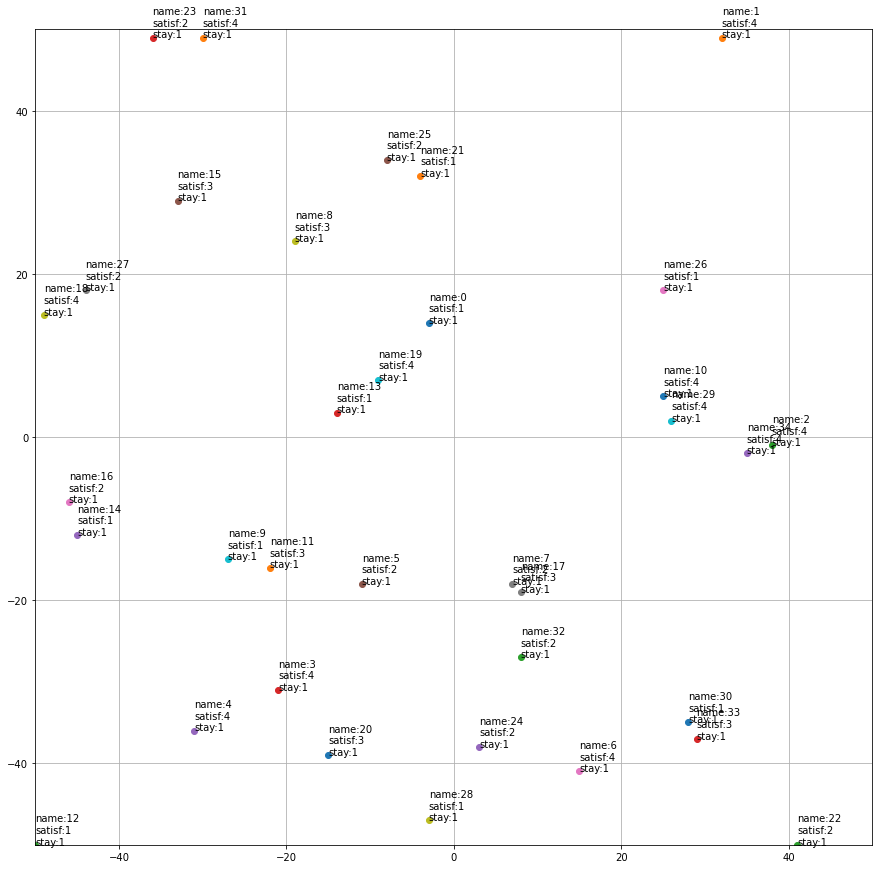

In [4]:
instance = PCTSP(I, a, b, pos, speed, c, m)
instance.plot_map(-R, R, -R, R)

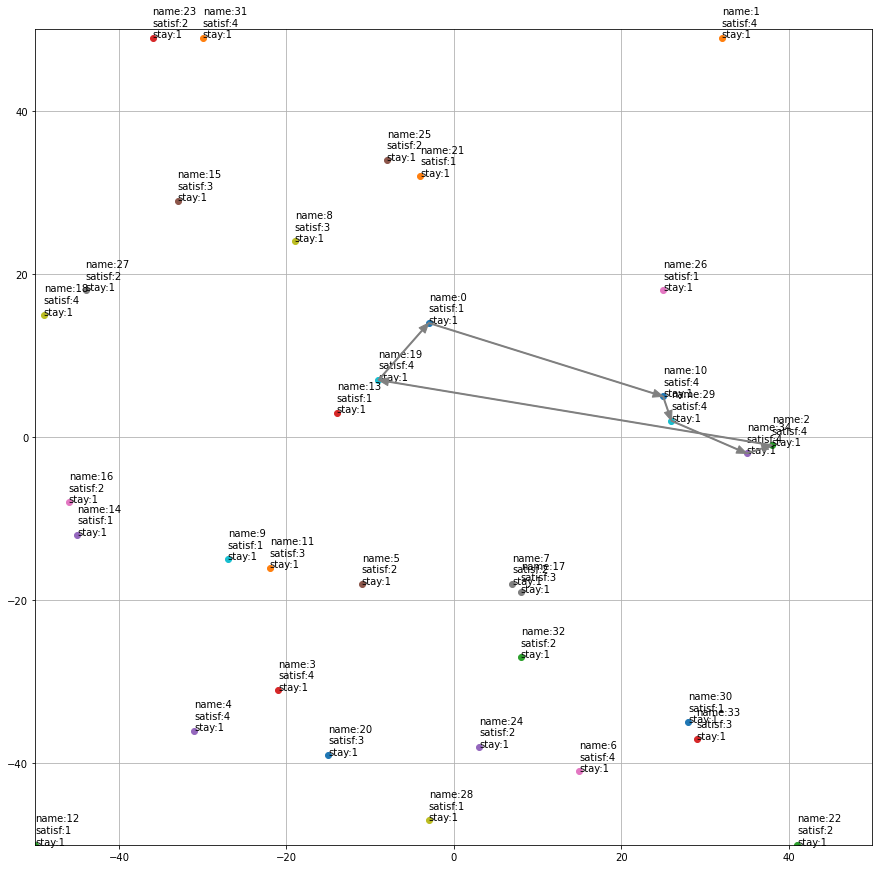

In [5]:
ans = instance.solve(start, T, C, threads=4, timeLimit=1)
instance.plot_route(ans, -R, R, -R, R)